## Генерируем данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
X, y = make_moons(n_samples=1_000, random_state=0, noise=0.3)

df = pd.DataFrame({
    'feat1': X[:, 0],
    'feat2': X[:, 1],
    'feat3': np.random.rand(X.shape[0]),
    'feat4': np.random.rand(X.shape[0]),
    'target': y
})

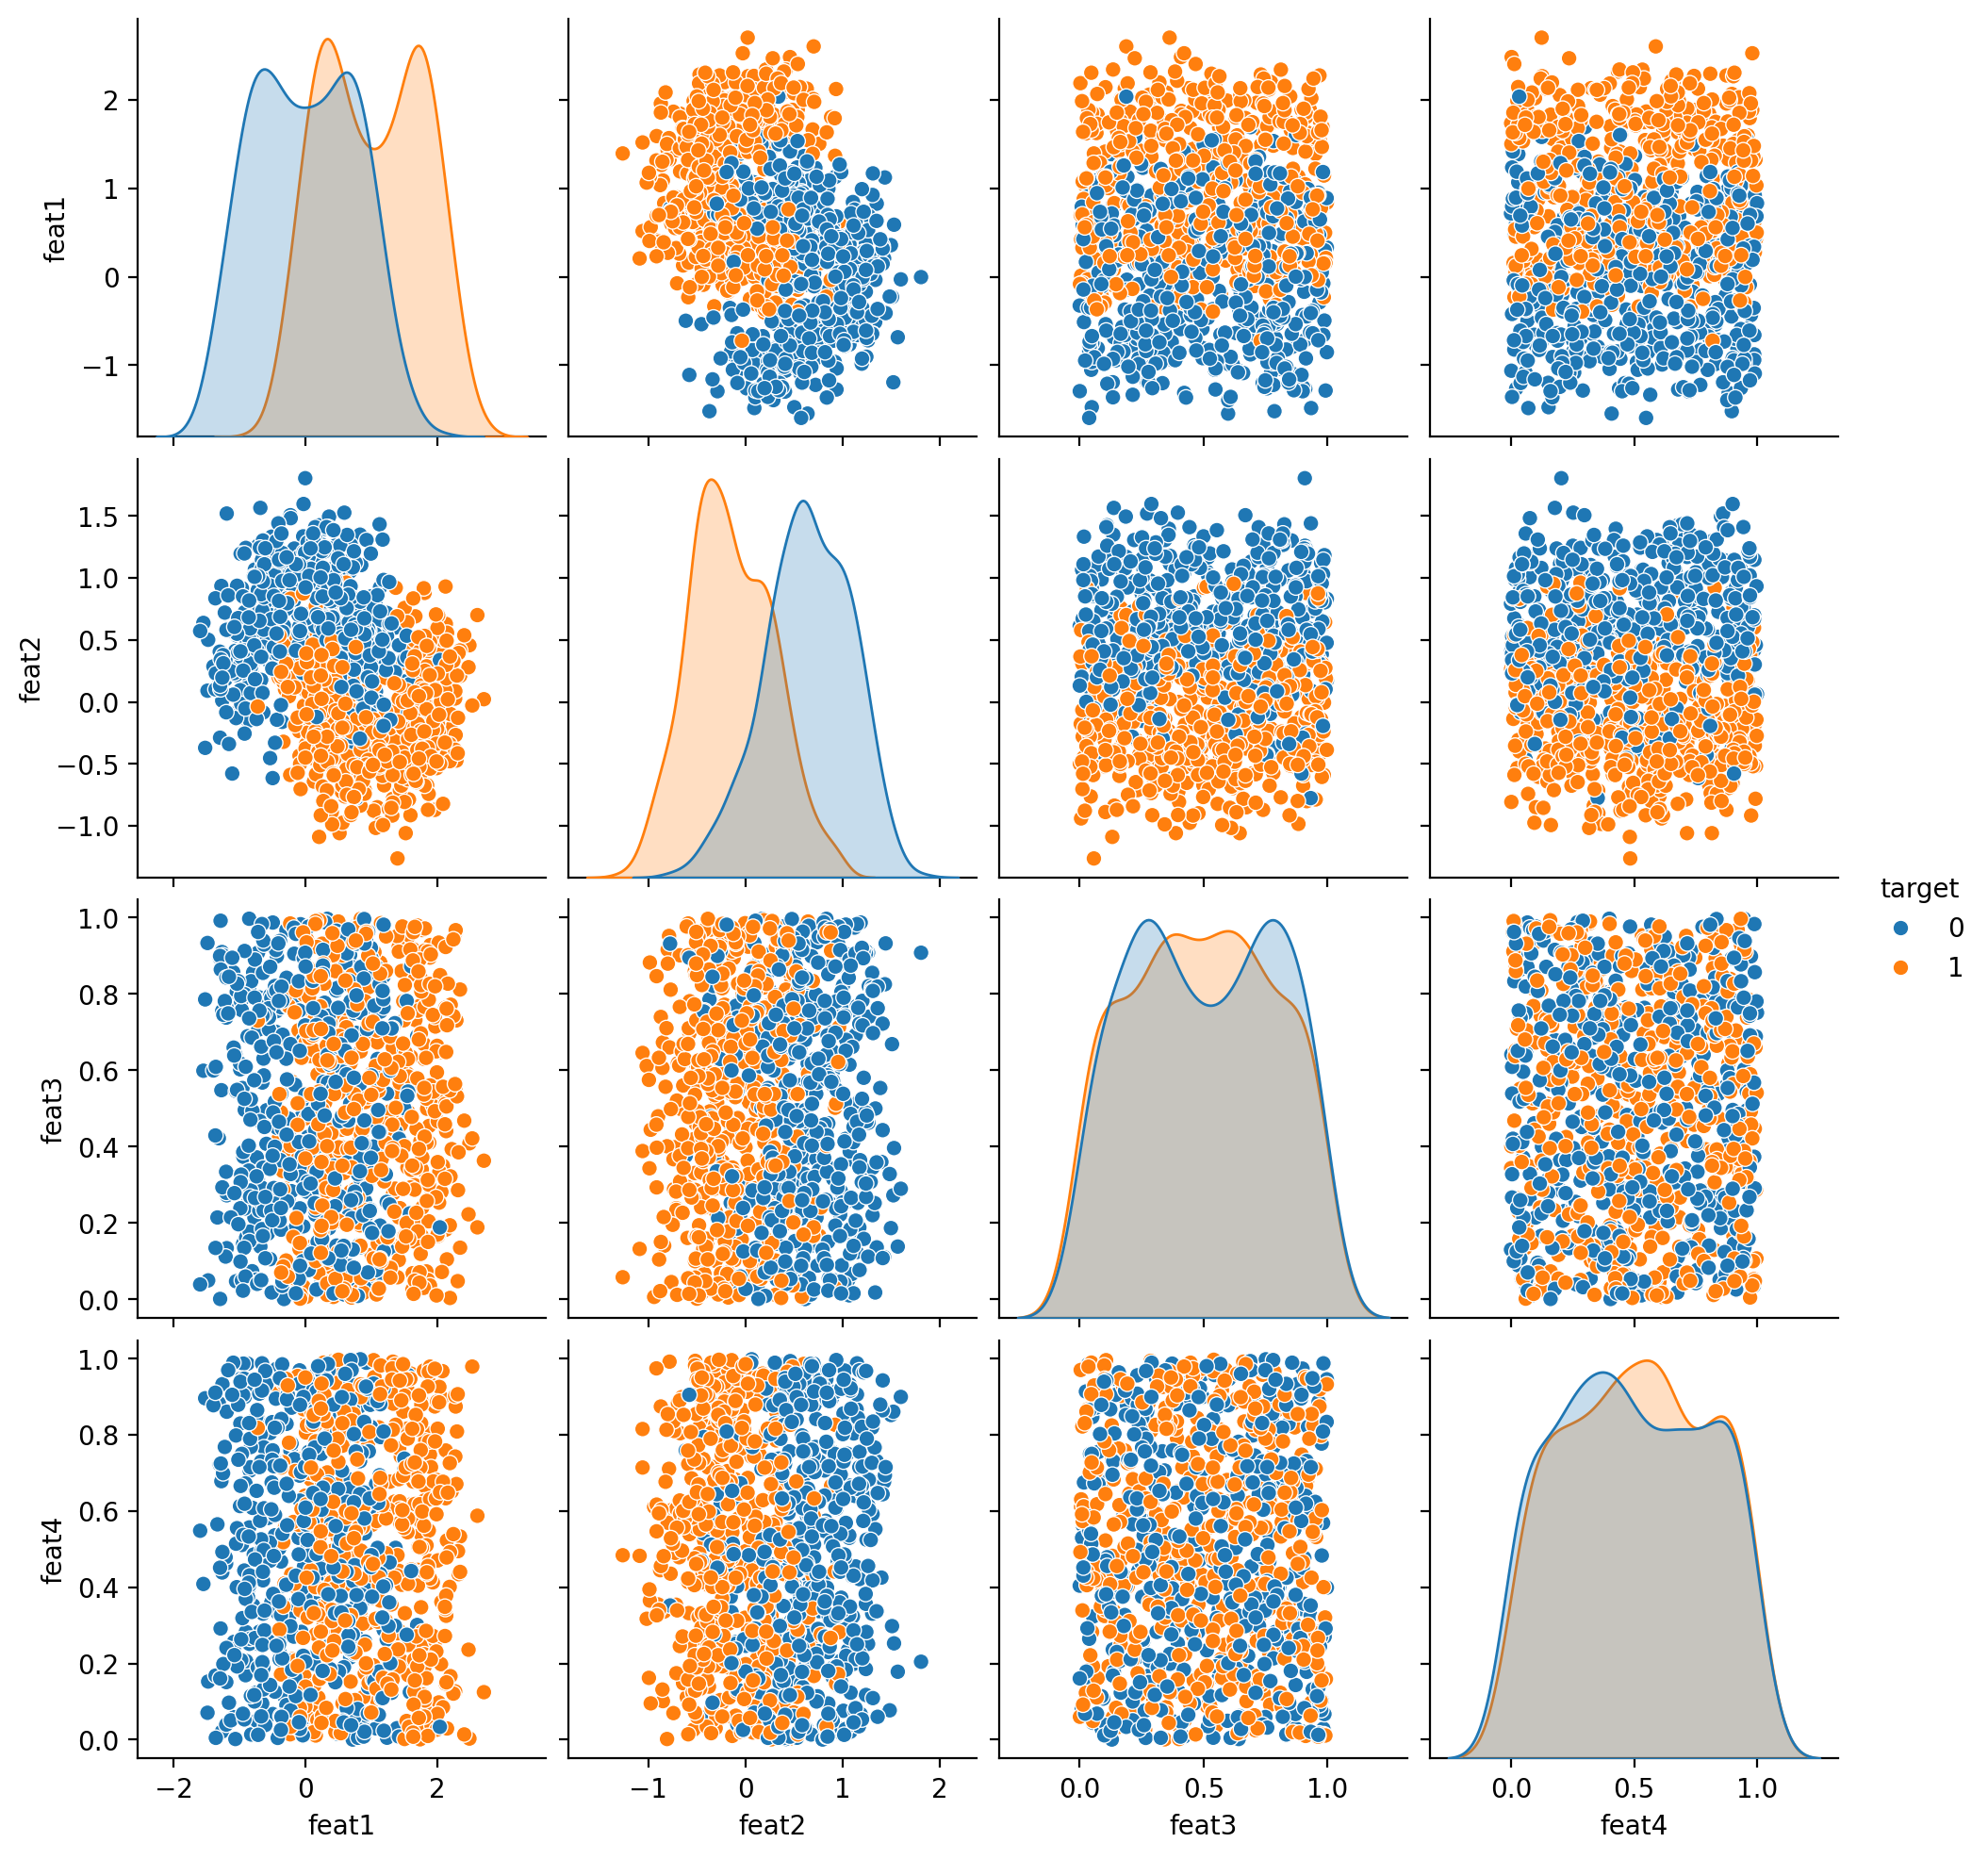

In [3]:
sns.pairplot(df, hue='target')

In [4]:
df.head()

,feat1,feat2,feat3,feat4,target
0,2.129573,0.629904,0.182592,0.759267,1
1,1.888882,0.146257,0.895571,0.748241,1
2,-0.190357,0.383993,0.976639,0.102568,0
3,-0.404416,0.195282,0.422373,0.909978,1
4,0.373012,-0.429716,0.129844,0.824971,1


## Инициализация PyCaret и Spark

In [5]:
from pycaret.classification import setup, compare_models, tune_model, evaluate_model, create_model

from pyspark.sql import SparkSession
from pycaret.parallel import FugueBackend

In [6]:
spark = (
    SparkSession.
    builder.
    appName('pycaret').
    config('spark.driver.memory', '2g').
    config('spark.executor.memory', '2g').
    getOrCreate()
)
    
s = setup(
  data=df, 
  target='target',
  n_jobs=1
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/28 17:47:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Description,Value
0,Session id,7930
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 5)"
4,Transformed data shape,"(1000, 5)"
5,Transformed train set shape,"(700, 5)"
6,Transformed test set shape,"(300, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 39720)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/opt/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rfi

## Сравнение доступных алгоритмов

In [7]:
%%time
best = compare_models(
  parallel=FugueBackend(spark)  
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8957,0.9573,0.9000,0.8965,0.8965,0.7914,0.7945,0.120
rf,Random Forest Classifier,0.8914,0.9557,0.8971,0.8919,0.8922,0.7829,0.7868,0.193
knn,K Neighbors Classifier,0.8900,0.9424,0.8971,0.8870,0.8908,0.7800,0.7822,0.028
lightgbm,Light Gradient Boosting Machine,0.8900,0.9504,0.8886,0.8965,0.8905,0.7800,0.7834,0.051
et,Extra Trees Classifier,0.8886,0.9581,0.8943,0.8897,0.8899,0.7771,0.7807,0.120
ada,Ada Boost Classifier,0.8800,0.9490,0.8800,0.8849,0.8801,0.7600,0.7641,0.107
dt,Decision Tree Classifier,0.8557,0.8557,0.8400,0.8709,0.8519,0.7114,0.7174,0.017
qda,Quadratic Discriminant Analysis,0.8343,0.9241,0.8257,0.8458,0.8331,0.6686,0.6726,0.019
nb,Naive Bayes,0.8329,0.9244,0.8229,0.8452,0.8314,0.6657,0.6697,0.026
lr,Logistic Regression,0.8329,0.9239,0.8257,0.8426,0.8316,0.6657,0.6698,0.016


CPU times: user 244 ms, sys: 37.7 ms, total: 281 ms
Wall time: 12.3 s


## Подбор гиперпараметров

In [ ]:
model = create_model('ada')

In [9]:
tuned_best = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9220,0.8857,0.8378,0.8611,0.7143,0.7155
1,0.9143,0.9478,0.8857,0.9394,0.9118,0.8286,0.8299
2,0.9000,0.9694,0.8857,0.9118,0.8986,0.8000,0.8003
3,0.8714,0.9473,0.8857,0.8611,0.8732,0.7429,0.7432
4,0.9714,0.9959,1.0000,0.9459,0.9722,0.9429,0.9444
5,0.9143,0.9612,0.8857,0.9394,0.9118,0.8286,0.8299
6,0.9286,0.9808,0.9429,0.9167,0.9296,0.8571,0.8575
7,0.9143,0.9959,0.9714,0.8718,0.9189,0.8286,0.8340
8,0.9429,0.9637,0.9714,0.9189,0.9444,0.8857,0.8872


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…